In [2]:
pip install meteostat

  Obtaining dependency information for meteostat from https://files.pythonhosted.org/packages/23/93/0d277de2b38238072b850e33fbd94e230951f2e5d7ac140ae221a05215b0/meteostat-1.6.7-py3-none-any.whl.metadata
Note: you may need to restart the kernel to use updated packages.


In [4]:
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from meteostat import Point, Daily

In [7]:
start = datetime(2016, 10, 31) 
end = datetime(2023, 10, 31) #data會有缺少是正常的，後面會再修改

In [8]:
location = Point(51.5072, 0.1276, 11) #設定地點(latitude, longitude, and altitude)

In [9]:
data = Daily(location, start, end)
data = data.fetch()

In [12]:
data.head()

,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
time,,,,,,,,,,
2016-10-31,12.8,10.0,17.0,NaN,NaN,NaN,6.6,NaN,NaN,NaN
2016-11-01,10.5,8.0,13.0,NaN,NaN,NaN,8.0,NaN,NaN,NaN
2016-11-02,8.1,6.0,11.0,NaN,NaN,NaN,9.6,NaN,NaN,NaN
2016-11-03,7.8,4.0,11.0,NaN,NaN,NaN,9.9,NaN,NaN,NaN
2016-11-04,9.5,8.0,12.0,NaN,NaN,NaN,9.0,NaN,NaN,NaN


In [13]:
data.tail()

,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
time,,,,,,,,,,
2023-10-27,10.2,8.3,12.8,NaN,NaN,225.0,22.1,46.3,994.6,NaN
2023-10-28,9.7,7.9,12.4,NaN,NaN,208.0,19.8,42.6,999.1,NaN
2023-10-29,10.0,7.4,12.8,NaN,NaN,197.0,17.0,35.2,1003.8,NaN
2023-10-30,10.3,8.7,12.6,NaN,NaN,215.0,19.0,37.0,1006.9,NaN
2023-10-31,10.3,8.2,12.9,NaN,NaN,211.0,21.4,40.8,1010.2,NaN


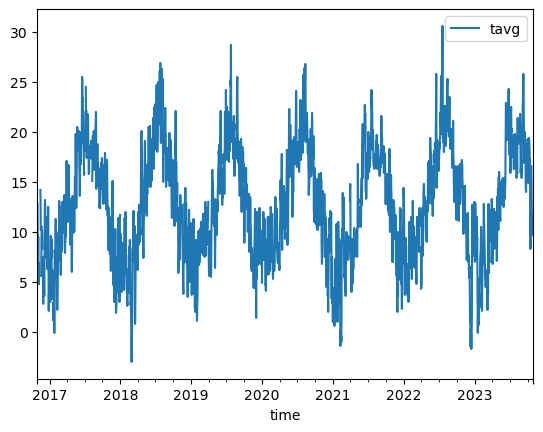

In [10]:
data.plot(y=['tavg'])#tavg表當日平均溫度
plt.show()

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2557 entries, 2016-10-31 to 2023-10-31
Freq: D
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   tavg    2531 non-null   float64
 1   tmin    2531 non-null   float64
 2   tmax    2531 non-null   float64
 3   prcp    1023 non-null   float64
 4   snow    0 non-null      float64
 5   wdir    2323 non-null   float64
 6   wspd    2531 non-null   float64
 7   wpgt    1843 non-null   float64
 8   pres    2089 non-null   float64
 9   tsun    0 non-null      float64
dtypes: float64(10)
memory usage: 219.7 KB


In [15]:
len(data['tavg'])

2557

In [16]:
data['number'] = np.arange((len(data['tavg'])))

In [18]:
data.head()

,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun,number
time,,,,,,,,,,,
2016-10-31,12.8,10.0,17.0,NaN,NaN,NaN,6.6,NaN,NaN,NaN,0
2016-11-01,10.5,8.0,13.0,NaN,NaN,NaN,8.0,NaN,NaN,NaN,1
2016-11-02,8.1,6.0,11.0,NaN,NaN,NaN,9.6,NaN,NaN,NaN,2
2016-11-03,7.8,4.0,11.0,NaN,NaN,NaN,9.9,NaN,NaN,NaN,3
2016-11-04,9.5,8.0,12.0,NaN,NaN,NaN,9.0,NaN,NaN,NaN,4


In [19]:
data['tavg'].fillna(method='ffill', inplace=True) 
#資料清洗，以previous代替缺失的數據 fillna:取代缺失的na；ffill:forward fill

In [20]:
x = np.array(data['number'])
y = np.array(data['tavg'])

In [21]:
#建立天氣模型

import pandas as pd
import matplotlib.ticker as ticker
from sklearn.metrics import mean_squared_error #回歸的統計誤差
from sklearn.linear_model import LinearRegression
from scipy.stats import norm,normaltest,probplot
from scipy import optimize
from matplotlib import style
from statistics import pstdev
import pylab 

In [22]:
def form(x,A,B,C,phi):
    return A + B * x + C * np.sin(np.radians(x + phi)) #若為cosin，則為x - phi

In [24]:
param, covariance = optimize.curve_fit(form, x, y, [0, 0, 0, 0]) #[0, 0, 0, 0]作為初始以最小化誤差
fit_sin = form(x, *param)

In [25]:
param

array([ 1.26079905e+01,  6.71430245e-05, -6.58131084e+00,  1.18240353e+01])

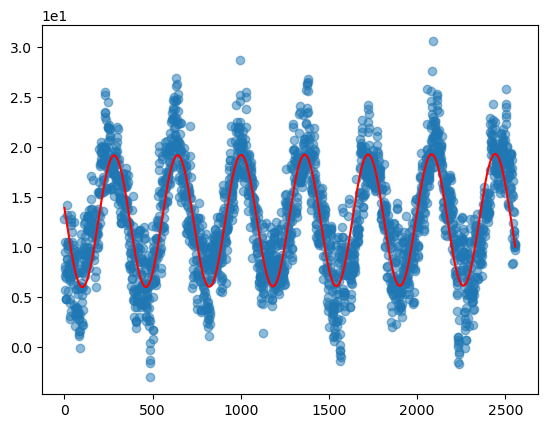

In [26]:
plt.scatter(x, y, label='data', alpha=0.5)
plt.plot(x, fit_sin, 'r-')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(500))  # Increase the spacing between ticks
plt.show()
#藍點是真實數據，紅線是用sin模型用出來的

In [27]:
projection_mean = y - fit_sin #y是真實數據；fit_sin是模型最適化的數據

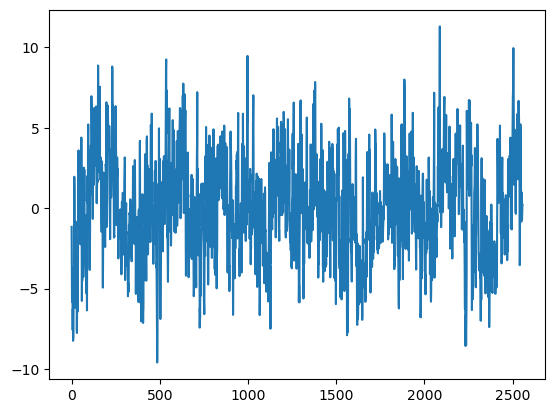

In [28]:
plt.plot(projection_mean)
plt.show() #會符合常態分配

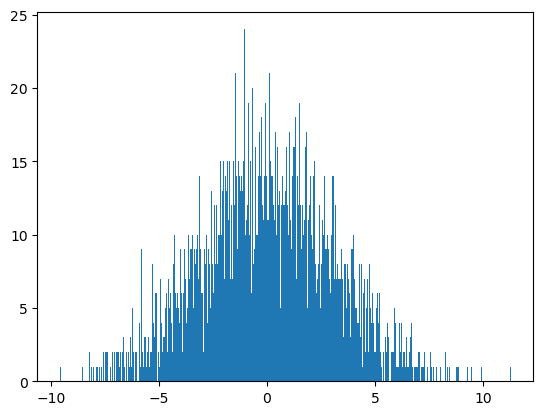

In [29]:
#Analyzing the Noise Distribution:符合常態分配
plt.hist(projection_mean, bins=500)
plt.show()

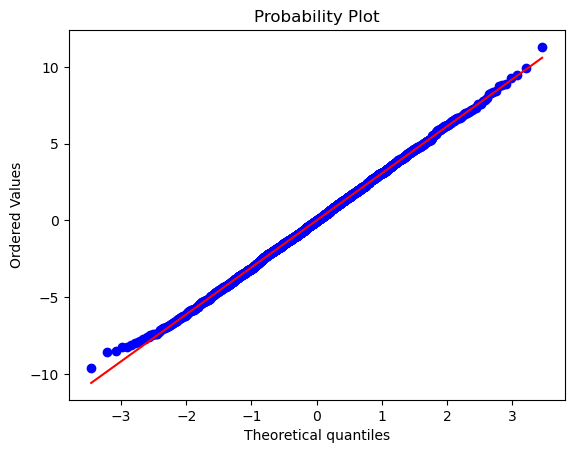

In [30]:
probplot(projection_mean, dist="norm", plot=pylab)
pylab.show()

##建立模型的第二方式：Ornstein-Uhlenbeck Process

b :  0.7989632009433061
a :  0.0005199079249939498
se :  33.05782586259691


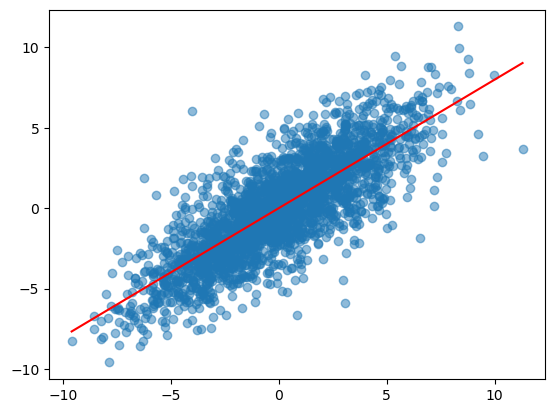

In [31]:
#建立模型的第二方式：Ornstein-Uhlenbeck Process
absc = projection_mean[:-1].reshape((-1, 1)) #從第一個到倒數第二個
ordo = projection_mean[1:]#從第二個到最後一個
model = LinearRegression(fit_intercept=True)
model.fit(absc, ordo)
b = model.coef_[0]
a = model.intercept_
x_test=np.linspace(min(absc[:-1]),max(absc[:-1]),num=len(absc)).reshape((-1, 1))
y_pred = model.predict(x_test)

se = mean_squared_error(ordo, y_pred)
print("b : ",b)
print("a : ", a)
print("se : ", se)

plt.scatter(absc,ordo,alpha=0.5)
plt.plot(x_test,y_pred,c="red")
plt.show()

In [32]:
K = -np.log(b)
theta = a/(1-b)
sigma = se*np.sqrt(-2*np.log(b)/(1-b**2))/10

In [33]:
print("K ：", K)
print("theta : ",theta)
print("sigma : ",sigma)

K ： 0.22444039066784713
theta :  0.002586133123057395
sigma :  3.6829080259528313


In [34]:
def OU(x,t,K,theta,sigma):
    res=[x]
    for i in range(t):
        ou_t = res[-1]*np.exp(-K)+theta*(1-np.exp(-K))+sigma*np.sqrt((1-np.exp(-2*K))/(2*K))*np.random.normal(0,1)
        res.append(ou_t)
    return np.array(res)

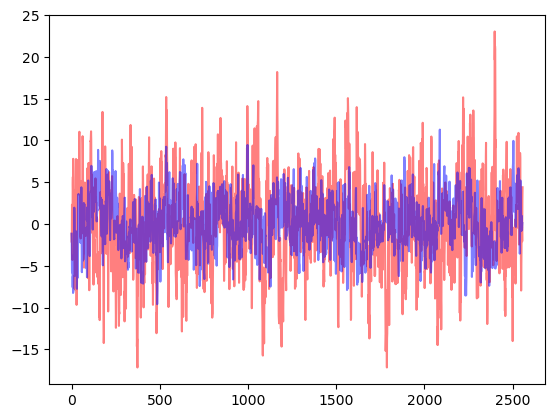

In [35]:
res= OU(projection_mean[0],len(projection_mean)-1,K,theta,sigma)
plt.plot(res,alpha=0.5,c="red")
plt.plot(projection_mean[:-1],alpha=0.5,c="blue")
plt.show()

In [36]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[int(result.size/2):]

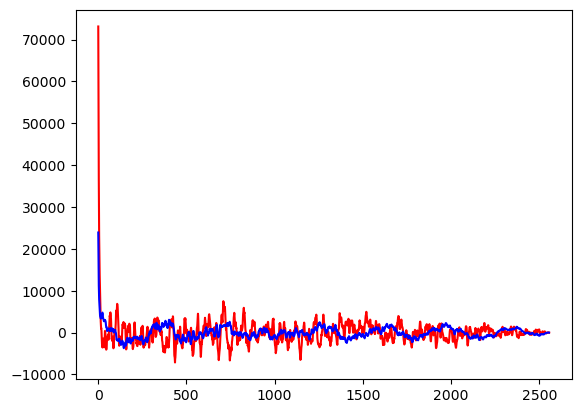

In [37]:
plt.plot(autocorr(res),c="red")
plt.plot(autocorr(projection_mean[:-1]),c="blue")
plt.show()

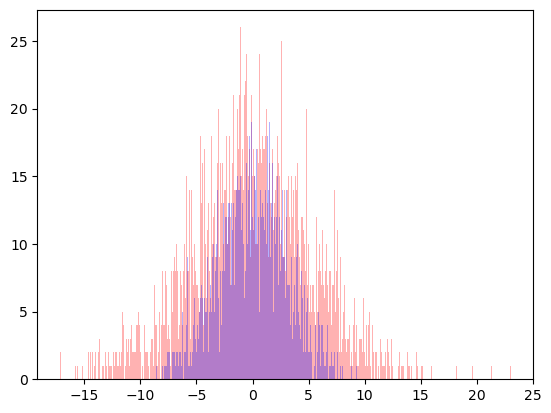

In [38]:
plt.hist(res,bins=500,color="red",alpha=0.3)
plt.hist(projection_mean[:-1],bins=500,color="blue",alpha=0.3)
plt.show()

進行預測

In [39]:
def pred_T(n,x0,t0):
    new_x = np.array([x0+i for i in range(N)])
    fit_cosin_future = form(new_x, *param)
    ou_test= OU(projection_mean[-1],n-1,K,theta,sigma)
    temprerature_prediction = fit_cosin_future + ou_test
    return temprerature_prediction

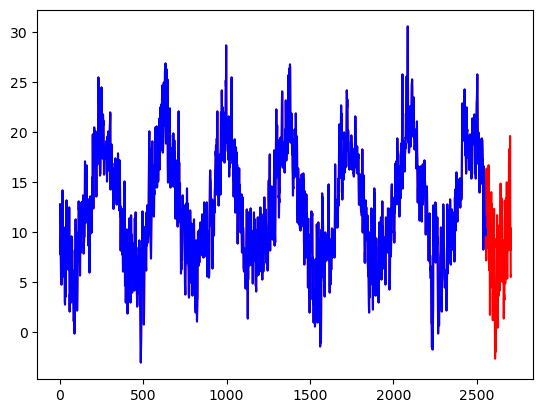

In [40]:
N = 30 * 5 #預測未來五個月，紅線即是預測的，每次導出的紅線都會不同，若嘗試很多次，則可以更精準
temprerature_prediction = pred_T(N, x[-1], y[-1])
plt.plot([i for i in range(len(x) + N)],list(y) + list(temprerature_prediction),c="red")
plt.plot(x,y,c="blue")
plt.show()

In [41]:
referential =y[-1]

In [42]:
def H(n,x0,t0):
    return (referential  *n - np.sum(pred_T(n,x0,t0)))

In [43]:
n_sim=1000    #模型跑1000次
sim = np.array([H(N,x[-1],y[-1]) for i in range(n_sim)])

In [44]:
mu_n = np.mean(sim)
sigma_n=pstdev(sim)
print("mu_n : ",mu_n) #true value of option
print("sigma_n : ",sigma_n) #標準差

mu_n :  346.8665591951356
sigma_n :  200.42314151258535


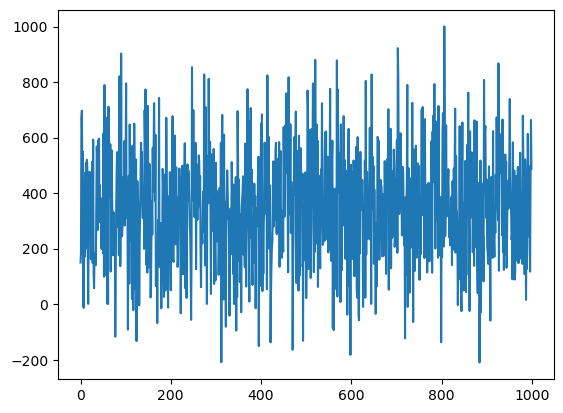

In [45]:
plt.plot(sim)
plt.show()

Pricing the HDD Call Option

In [47]:
r = 0.0493/365 #risk free rate

In [48]:
def call_hdd(t, strike, r):
    return( np.exp(- r  *t) * ((strike-mu_n) * (norm.cdf(alpha_n)-norm.cdf(-mu_n/sigma_n)) + sigma_n/np.sqrt(2 * np.pi) * (np.exp((-alpha_n ** 2)/2)-np.exp(-((mu_n/sigma_n) ** 2)/2))) )

In [50]:
strike_array = np.linspace(0, 1000, num=1000) #strike price設為1000，1000次

In [51]:
prime_aray = []
for strike in strike_array:
    alpha_n = (strike - mu_n)/sigma_n
    print("alpha_n : ", alpha_n)
    print("N : ", N)
    print("mu_n", mu_n)
    prime_aray.append(call_hdd(N, strike, r))
    print("CALL HDD Strike ", strike, " : ", prime_aray[-1])

alpha_n :  -1.7306712018250374
N :  150
mu_n 346.8665591951356
CALL HDD Strike  0.0  :  0.0
alpha_n :  -1.7256767635907773
N :  150
mu_n 346.8665591951356
CALL HDD Strike  1.001001001001001  :  0.00021920438588879913
alpha_n :  -1.7206823253565167
N :  150
mu_n 346.8665591951356
CALL HDD Strike  2.002002002002002  :  0.0008793474780143669
alpha_n :  -1.7156878871222567
N :  150
mu_n 346.8665591951356
CALL HDD Strike  3.0030030030030033  :  0.001984240494160377
alpha_n :  -1.7106934488879966
N :  150
mu_n 346.8665591951356
CALL HDD Strike  4.004004004004004  :  0.0035377164043197597
alpha_n :  -1.7056990106537364
N :  150
mu_n 346.8665591951356
CALL HDD Strike  5.005005005005005  :  0.0055436299260997746
alpha_n :  -1.7007045724194758
N :  150
mu_n 346.8665591951356
CALL HDD Strike  6.0060060060060065  :  0.008005857518565102
alpha_n :  -1.6957101341852159
N :  150
mu_n 346.8665591951356
CALL HDD Strike  7.007007007007008  :  0.010928297374172289
alpha_n :  -1.6907156959509557
N :  150


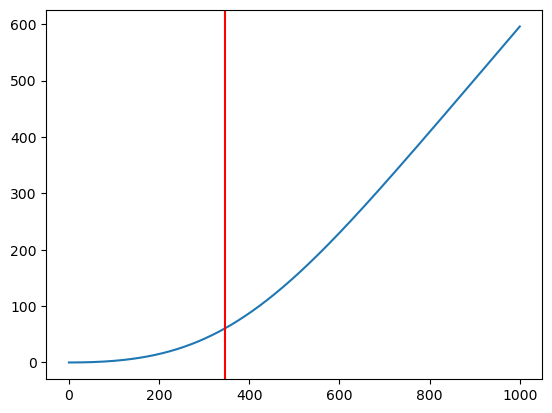

In [52]:
plt.plot(strike_array, prime_aray)
plt.axvline(mu_n, c="red")
plt.show()